In [1]:
import boule as bl
import ensaio
import numpy as np
import pandas as pd
import pygmt
import verde as vd
import xarray as xr
import harmonica as hm
import scipy as scipy
from numba import njit
import matplotlib.pyplot as plt

# Load Moho & LAB and NearestNDInterpolator Function

In [2]:
# Moho                     
moho_file_path = 'moho_depth.csv'
moho_df = pd.read_csv(moho_file_path)

camlab_file_path = "D:\\Amitava\\Projects\\Perple_X\\V2RhoT_gibbs\\LAB_geoid_data\\CAM2022_lithosphere.xyz"
camlab_df = pd.read_csv(camlab_file_path, delim_whitespace=True, header=None, names=['Latitude', 'Longitude', 'Depth'])

fname = ensaio.fetch_earth_topography(version=1)
topo = xr.load_dataarray(fname)

# Topo
topo_file_path = r"D:\Amitava\Projects\Perple_X\topo\etopo2_downsampled.csv"
topo_df = pd.read_csv(topo_file_path, usecols=['x', 'y', 'z'])
topo_df.rename(columns={'x': 'Longitude', 'y': 'Latitude', 'z': 'Topo'}, inplace=True)      # Rename columns to match interpolation logic
topo_df = topo_df[['Latitude', 'Longitude', 'Topo']]  # Reorder columns

C:\Users\DELL\AppData\Local\Temp\ipykernel_24272\1790229125.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  camlab_df = pd.read_csv(camlab_file_path, delim_whitespace=True, header=None, names=['Latitude', 'Longitude', 'Depth'])


In [3]:
moho_func = scipy.interpolate.NearestNDInterpolator(list(zip(moho_df['Latitude'], moho_df['Longitude'])), moho_df['Moho'])
camlab_func = scipy.interpolate.NearestNDInterpolator(list(zip(camlab_df['Latitude'], camlab_df['Longitude'])), camlab_df['Depth'])
topo_func = scipy.interpolate.NearestNDInterpolator(list(zip(topo_df['Latitude'], topo_df['Longitude'])), topo_df['Topo'])

In [4]:
#region = [west, east, south, north]
#region = [-78, -53, -57, -20] # SA
#region = [112, 155, -45, -10]  # Australia
#region = [68, 98, 6, 38]  # India
region = [-179.9, 179.9, -89.9, 89.9] # World

In [5]:
import random

# Get a random integer between 1 and 10 (inclusive)
random_integer = random.random()
print(random_integer)

0.1780928454031605


# Gravity field for different density layers

In [ ]:
%%time
# Use the WGS84 ellipsoid to obtain the mean Earth radius which we'll use to
# reference the tesseroid
ellipsoid = bl.WGS84
mean_radius = ellipsoid.mean_radius

# Define tesseroid with top surface at the mean Earth radius, a thickness of
tesseroids = []
density = []
tess_den = []
dlong=5
dlat=5
longitude_max=175
longitude_min=-175
latitude_max=85
latitude_min=-85
depth_min=0
#depth_min=mean_radius
#depth_max=mean_radius-100e3
ddepth=10e3

for lat in np.arange(latitude_min, latitude_max,dlat):   # step of 1 degree
    for lon in np.arange(longitude_min, longitude_max,dlong):
        #depth_max = mean_radius - (camlab_func(lat, lon) *1e3)
        depth_max = (camlab_func(lat, lon) *1e3)
        for depth in np.arange(depth_max,depth_min,-ddepth):
            #r_bottom = float(depth)
            #r_top = float(min(depth + ddepth, mean_radius))
            r_bottom = float(mean_radius - depth)
            r_top = float(mean_radius - depth + ddepth)

            tesseroids.append([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top])

            # Assigning density for various layers
            topo = topo_func(lat, lon)
            moho = moho_func(lat, lon)
            lab = camlab_func(lat, lon)

            #depth_top = mean_radius - r_top
            #depth_bottom = mean_radius - r_bottom
            #depth_mid = 0.5 * (depth_top + depth_bottom)
            '''
            if topo < 0:
                rho_top, rho_bottom = 1000.0, 1040.0  # Ocean
            # elif topo >= 0 and depth_mid < moho:
            #     rho_top, rho_bottom = 2300.0, 2700.0  # Sediment 
            elif depth <= moho:
                rho_top, rho_bottom = 2670.0, 3000.0  # Crust
            elif depth <= lab:
                rho_top, rho_bottom = 3250.0, 3350.0  # Lithospheric mantle
            else:
                rho_top, rho_bottom = 3350.0, 3370.0  # Deeper mantle
            '''
            if topo < 0:
                if depth <= topo:
                    rho_top, rho_bottom = 1000.0, 1040.0  # Ocean water
                elif depth <= moho:
                    rho_top, rho_bottom = 2670.0, 3000.0  # Crust
                elif depth <= lab:
                    rho_top, rho_bottom = 3250.0, 3350.0  # Lithospheric mantle
                else:
                    rho_top, rho_bottom = 3350.0, 3370.0  # Deeper mantle
            else:
                if depth <= moho:
                    rho_top, rho_bottom = 2670.0, 3000.0  # Crust
                elif depth <= lab:
                    rho_top, rho_bottom = 3250.0, 3350.0  # Lithospheric mantle
                else:
                    rho_top, rho_bottom = 3350.0, 3370.0  # Deeper mantle

            # Linear profile
            radius_mid = 0.5 * (r_top + r_bottom) #mean_radius-depth
            slope = (rho_top - rho_bottom) / (r_top - r_bottom)
            density_mid = slope * (radius_mid - r_bottom) + rho_bottom
            density.append(density_mid)
            tess_den.append([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top, density_mid])
                

# Define a linear density function. We should use the jit decorator so Numba
# can run the forward model efficiently.
#"""Linear density function"""
#top = mean_radius
#bottom = mean_radius - 200e3
#density_top = xr.where(topo > 0, 2670.0, 1040.0)
#density_bottom = 3000
#@njit
#def density(radius):
#    slope = (density_top - density_bottom) / (top - bottom)
#    return slope * (radius - bottom) + density_bottom

#def density(radius):
#    return random.randint(2670,3270)


# Define computation points on a regular grid at 100km above the mean Earth
# radius

coordinates = vd.grid_coordinates(region=region,shape=(80, 80),extra_coords=100e3 + ellipsoid.mean_radius,)

# Compute the radial component of the acceleration
gravity = hm.tesseroid_gravity(coordinates, tesseroids, density, field="g_z")
print(gravity)
grid = vd.make_xarray_grid(coordinates, gravity, data_names="gravity", extra_coords_names="extra")
#gd_mean=grid.mean()
#gd_new=
# Plot the gravitational field
fig = pygmt.Figure()

title = "Downward component of gravitational acceleration"

with pygmt.config(FONT_TITLE="16p"):
    fig.grdimage(region=region,projection="W25c",grid=grid.gravity,frame=["a", f"+t{title}"],cmap="viridis",)
    
vmin = float(grid.gravity.min())
vmax = float(grid.gravity.max())

fig.colorbar(cmap=True,frame=[f"x+lGravity [mGal]",f"a{vmin:.1f},{vmin:.1f},{vmax:.1f}"])
fig.coast(shorelines="1p,black")

fig.show()

In [ ]:
np.shape(np.arange(latitude_min, latitude_max,dlat)),np.shape(np.arange(longitude_min, longitude_max,dlong)),np.shape(np.arange(depth_max,depth_min,ddepth))

In [ ]:
tesseroids = np.array(tesseroids)
density = np.array(density) 
tess_den = np.array(tess_den) 

In [ ]:
np.shape(tesseroids)

In [ ]:
np.shape(density)

In [ ]:
tess_den

In [ ]:
np.shape(tess_den)

In [ ]:
plt.scatter(tess_den[:, 0], tess_den[:, 2], c=tess_den[:, 6], cmap='viridis', s=2)
plt.colorbar(label="Density (kg/m³)")

In [ ]:
depth_target = 100e3  # 40 km depth
radius_target = mean_radius - depth_target
mid_radius = 0.5 * (tess_den[:, 4] + tess_den[:, 5])
mask = np.abs(mid_radius - radius_target) < (ddepth / 2)
subset = tess_den[mask]
lon_center = 0.5 * (subset[:, 0] + subset[:, 1])
lat_center = 0.5 * (subset[:, 2] + subset[:, 3])
density = subset[:, 6]
plt.scatter(lon_center, lat_center, c=density, cmap='viridis', s=2)
plt.title(f"Density at {depth_target/1e3:.0f} km depth")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Density (kg/m³)")
plt.show()


In [ ]:
print("First few r_bottom values:", tess_den[:5, 4])
print("Should be ~6,000,000 (not hundreds of thousands)")


# Gravity Field for random density

[[15646.1022479  15636.10704513 15639.0702517  ... 15644.31701344
  15653.54699686 15629.3141045 ]
 [15556.69997547 15543.74673409 15501.66707172 ... 15633.66496222
  15617.75182364 15586.66630396]
 [15773.12578989 15712.6298375  15652.37254479 ... 15969.99432148
  15902.07424565 15787.3770032 ]
 ...
 [16197.85933999 16144.02976939 16121.2650558  ... 16323.73903919
  16270.988811   16211.2888573 ]
 [16328.01464068 16301.789655   16268.01942105 ... 16362.36518809
  16337.3844514  16313.62144232]
 [16529.79084266 16537.53118074 16550.68069348 ... 16538.81463981
  16552.06920707 16540.89055862]]


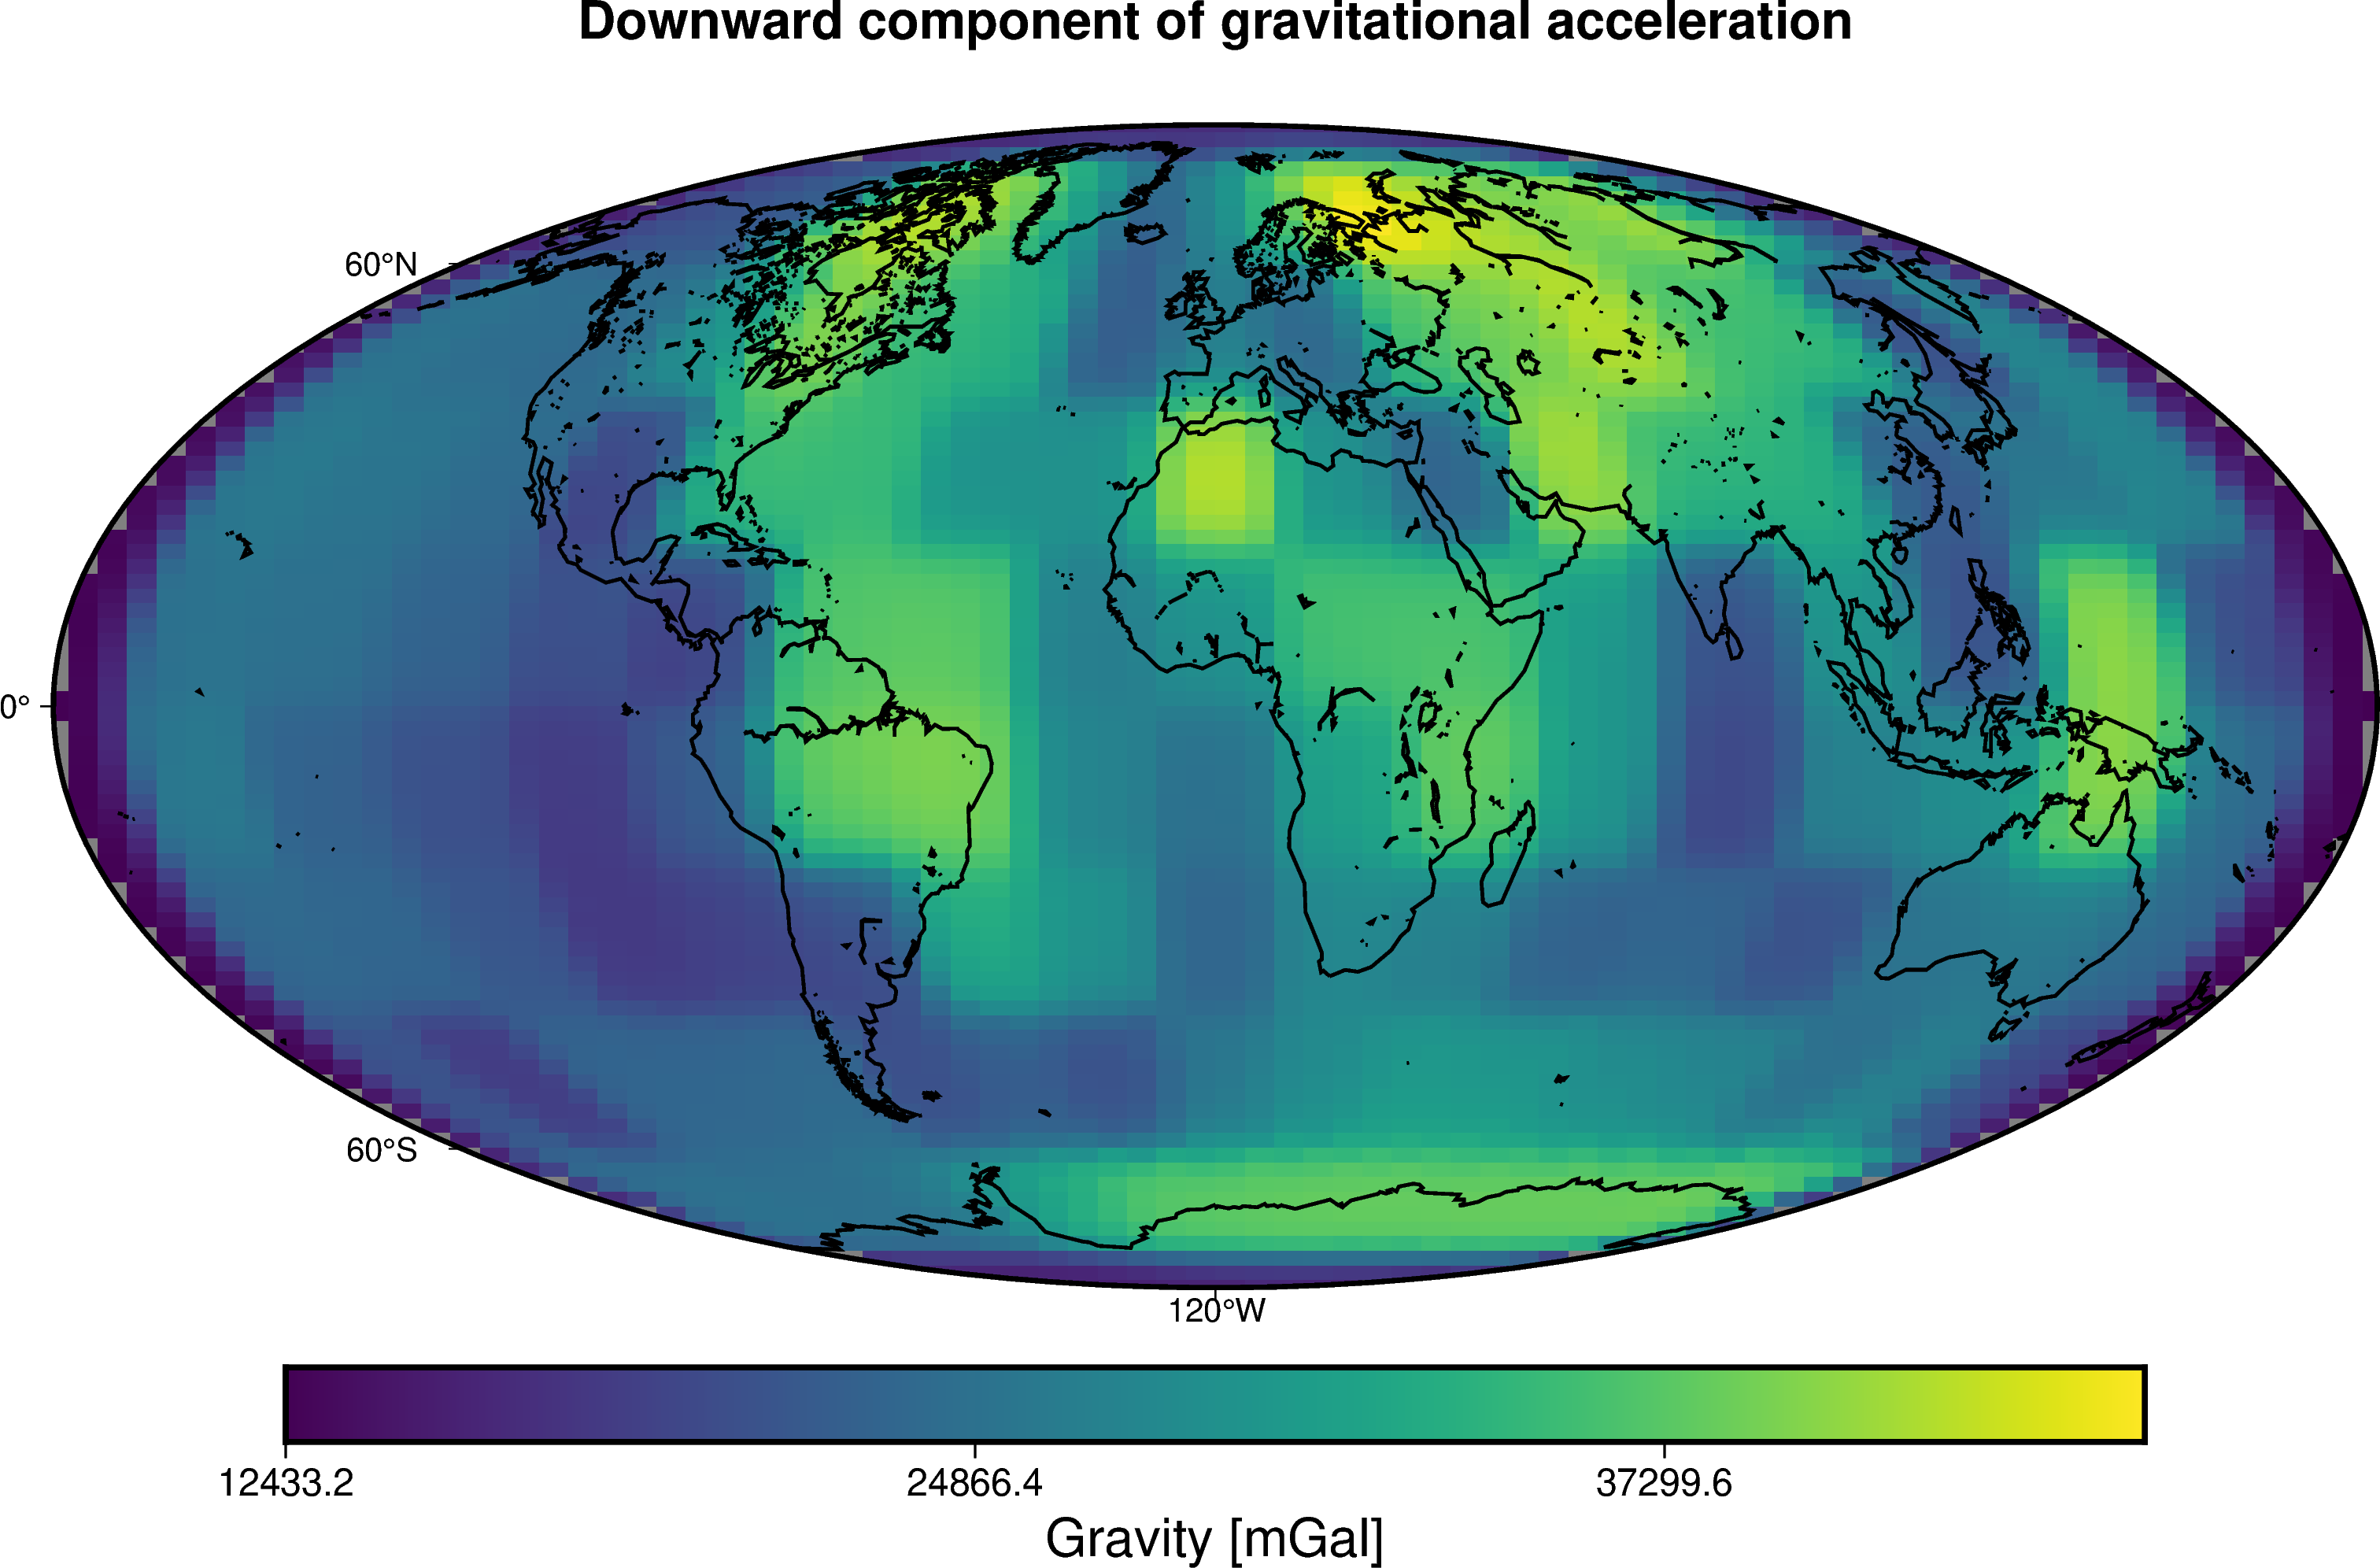

CPU times: total: 24.7 s
Wall time: 11.4 s


In [6]:
%%time
# Use the WGS84 ellipsoid to obtain the mean Earth radius which we'll use to
# reference the tesseroid
ellipsoid = bl.WGS84
mean_radius = ellipsoid.mean_radius

# Define tesseroid with top surface at the mean Earth radius, a thickness of
# 10km and a linear density function

tesseroids = (
    [73, 79, 8, 15, mean_radius - 5e3, mean_radius],   # SW
    [73, 79, 8, 15, mean_radius - 10e3, mean_radius],   # SE
    [73, 79, 8, 15, mean_radius - 20e3, mean_radius],  # NW
    [73, 79, 8, 15, mean_radius - 35e3, mean_radius],  # NE
)
'''
tesseroids = []
dlong=20
dlat=20
longitude_max=170
longitude_min=-170
latitude_max=80
latitude_min=-80
depth_min=mean_radius
depth_max=mean_radius-100e3
ddepth=100e3

for lat in np.arange(latitude_min, latitude_max,dlat):   # step of 1 degree
    for lon in np.arange(longitude_min, longitude_max,dlong):
        #for depth in np.arange(depth_max,depth_min,ddepth):
            #if depth depth = camlab_func(lat, lon) *1e3
        depth = camlab_func(lat, lon) *1e3
        tesseroids.append([float(lon), float(lon + dlong),float(lat), float(lat + dlat),float(mean_radius - depth),float(mean_radius)])
                
'''
# Define a linear density function. We should use the jit decorator so Numba
# can run the forward model efficiently.
#"""Linear density function"""
top = mean_radius
bottom = mean_radius - 200e3
density_top = 2670
density_bottom = 3000
@njit
#def density(radius):
#    slope = (density_top - density_bottom) / (top - bottom)
#    return slope * (radius - bottom) + density_bottom

def density(radius):
    return random.randint(2670,3270)


# Define computation points on a regular grid at 100km above the mean Earth
# radius
coordinates = vd.grid_coordinates(region=region,shape=(80, 80),extra_coords=100e3 + ellipsoid.mean_radius,)

# Compute the radial component of the acceleration
gravity = hm.tesseroid_gravity(coordinates, tesseroids, density, field="g_z")
print(gravity)
grid = vd.make_xarray_grid(coordinates, gravity, data_names="gravity", extra_coords_names="extra")
#gd_mean=grid.mean()
#gd_new=
# Plot the gravitational field
fig = pygmt.Figure()

title = "Downward component of gravitational acceleration"

with pygmt.config(FONT_TITLE="16p"):
    fig.grdimage(region=region,projection="W25c",grid=grid.gravity,frame=["a", f"+t{title}"],cmap="viridis",)
    
vmin = float(grid.gravity.min())
vmax = float(grid.gravity.max())

fig.colorbar(cmap=True,frame=[f"x+lGravity [mGal]",f"a{vmin:.1f},{vmin:.1f},{vmax:.1f}"])
fig.coast(shorelines="1p,black")

fig.show()

In [7]:
np.shape(np.arange(latitude_min, latitude_max,dlat)),np.shape(np.arange(longitude_min, longitude_max,dlong)),np.shape(np.arange(depth_max,depth_min,ddepth))

((8,), (17,), (1,))

In [8]:
16*34*2

1088

In [9]:
np.shape(tesseroids)

(136, 6)

In [10]:
2240-2176

64